In [17]:
# Use Erdos_Spring_2025 conda env as created
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [19]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition', 'height', 'weight']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition', 'bmi']


In [20]:
# def compare_models_with_tuning(df, col, test_size=0.2, random_state=1205):
#     target_col = col 
#     y = df[target_col]
#     #Drop the target columns, so the rest are feature columns
#     X = df.drop(columns=target_col)
    
#     # Initial split: training and test sets
#     X_train_init, X_test, y_train_init, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state
#     )
    
#     # Further split: training and validation sets (e.g., 20% of training goes to validation)
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_train_init, y_train_init, test_size=test_size, random_state=random_state
#     )

#     models = {
#         "GradientBoosting": (GradientBoostingClassifier(random_state=random_state), {
#             'n_estimators': [100, 200, 300],
#             'learning_rate': [0.01, 0.05, 0.1],
#             'max_depth': [3, 5, 7],
#             'subsample': [0.7, 0.85, 1.0],
#             'min_samples_split': [2, 5, 10]
#         }),
#         "RandomForest": (RandomForestClassifier(random_state=random_state), {
#             'n_estimators': [100, 200, 500],
#             'max_depth': [None, 10, 20],
#             'max_features': ['sqrt', 'log2', None],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4, 8]
#         }),
#         "XG Boost Classifier": (xgb.XGBClassifier(objective='reg:squarederror', random_state=random_state),{
#            'n_estimators': [100, 200, 300],
#             'learning_rate': [0.01, 0.05, 0.1],
#             'max_depth': [3, 5, 7],
#             'subsample': [0.7, 0.85, 1.0] 
#         })
#     }


#     results = {
#         'Model': [],
#         'Train Accuracy': [],
#         'Test Accuracy': []
#     }

#     for name, (model, param_grid) in models.items():
#         print(f"Tuning {name}...")
#         grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
#         grid.fit(X_train, y_train)

#         best_model = grid.best_estimator_
#         y_train_pred = best_model.predict(X_val)
#         y_test_pred = best_model.predict(X_test)

#         acc_train = accuracy_score(y_val, y_train_pred)
#         acc_test = accuracy_score(y_test, y_test_pred)

#         results['Model'].append(name)
#         results['Train Accuracy'].append(acc_train * 100)
#         results['Test Accuracy'].append(acc_test * 100)

#         print(f"{name} - Best Params: {grid.best_params_}")
#         print(f"Train Accuracy: {acc_train * 100:.2f}%")
#         print(f"Test Accuracy: {acc_test * 100:.2f}%")
#         print("-" * 30)
        
#     # === Add Mean Model (Most Frequent Class) ===
#     dummy_mean = DummyClassifier(strategy="most_frequent", random_state=random_state)
#     dummy_mean.fit(X_train, y_train)
#     acc_train_mean = accuracy_score(y_val, dummy_mean.predict(X_val))
#     acc_test_mean = accuracy_score(y_test, dummy_mean.predict(X_test))

#     results['Model'].append("Mean (Most Frequent)")
#     results['Train Accuracy'].append(acc_train_mean * 100)
#     results['Test Accuracy'].append(acc_test_mean * 100)
    
#     print(f"Mean (Most Frequent)")
#     print(f"Train Accuracy: {acc_train_mean * 100:.2f}%")
#     print(f"Test Accuracy: {acc_test_mean * 100:.2f}%")
#     print("-" * 30)

#     # === Add Random Model (Uniform Sampling) ===
#     dummy_random = DummyClassifier(strategy="uniform", random_state=random_state)
#     dummy_random.fit(X_train, y_train)
#     acc_train_random = accuracy_score(y_val, dummy_random.predict(X_val))
#     acc_test_random = accuracy_score(y_test, dummy_random.predict(X_test))

#     results['Model'].append("Random")
#     results['Train Accuracy'].append(acc_train_random * 100)
#     results['Test Accuracy'].append(acc_test_random * 100)
    
#     print(f"Random")
#     print(f"Train Accuracy: {acc_train_random * 100:.2f}%")
#     print(f"Test Accuracy: {acc_test_random * 100:.2f}%")
#     print("-" * 30)

#     # Create DataFrame for plotting
#     df_result = pd.DataFrame(results)

#     # Melt for plotting with seaborn
#     df_plot = df_result.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

#     # Plot
#     plt.figure(figsize=(10, 6))
#     sns.barplot(data=df_plot, x='Accuracy', y='Model', hue='Dataset', palette='Set2')
#     #plt.title("Model Comparison: Train vs Test Accuracy")
#     plt.xlabel("Accuracy (%)")
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
#     plt.xlim(0, 105)
#     plt.tight_layout()
#     plt.show()

In [21]:
def compare_models_with_tuning(df, col, test_size=0.2, random_state=1205):
    target_col = col 
    y = df[target_col]
    X = df.drop(columns=target_col)
    
    # Initial split: training and test sets
    X_train_init, X_test, y_train_init, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Further split: training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_init, y_train_init, test_size=test_size, random_state=random_state
    )

    models = {
        "GradientBoosting": (GradientBoostingClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.85, 1.0],
            'min_samples_split': [2, 5, 10]
        }),
        "RandomForest": (RandomForestClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4, 8]
        }),
        "XG Boost Classifier": (xgb.XGBClassifier(objective='reg:squarederror', random_state=random_state), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.85, 1.0]
        })
    }

    results = {
        'Model': [],
        'Train Accuracy': [],
        'Test Accuracy': []
    }

    for name, (model, param_grid) in models.items():
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_train_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)

        acc_train = accuracy_score(y_val, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)

        prec_train = precision_score(y_val, y_train_pred, average='weighted', zero_division=0)
        prec_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

        rec_train = recall_score(y_val, y_train_pred, average='weighted', zero_division=0)
        rec_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

        f1_train = f1_score(y_val, y_train_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        results['Model'].append(name)
        results['Train Accuracy'].append(acc_train * 100)
        results['Test Accuracy'].append(acc_test * 100)

        print(f"{name} - Best Params: {grid.best_params_}")
        print(f"Accuracy: Test {acc_test * 100:.2f}%, Train {acc_train * 100:.2f}%")
        print(f"Precision: Test {prec_test * 100:.2f}%, Train {prec_train * 100:.2f}%")
        print(f"Recall: Test {rec_test * 100:.2f}%, Train {rec_train * 100:.2f}%")
        print(f"F1 Score: Test {f1_test * 100:.2f}%, Train {f1_train * 100:.2f}%")
        print("-" * 30)

    # === Dummy Models ===
    dummy_models = {
        "Mean (Most Frequent)": DummyClassifier(strategy="most_frequent", random_state=random_state),
        "Random": DummyClassifier(strategy="uniform", random_state=random_state)
    }

    for name, dummy in dummy_models.items():
        dummy.fit(X_train, y_train)
        y_train_pred = dummy.predict(X_val)
        y_test_pred = dummy.predict(X_test)

        acc_train = accuracy_score(y_val, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)

        prec_train = precision_score(y_val, y_train_pred, average='weighted', zero_division=0)
        prec_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

        rec_train = recall_score(y_val, y_train_pred, average='weighted', zero_division=0)
        rec_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

        f1_train = f1_score(y_val, y_train_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        results['Model'].append(name)
        results['Train Accuracy'].append(acc_train * 100)
        results['Test Accuracy'].append(acc_test * 100)

        print(f"{name}")
        print(f"Accuracy: Test {acc_test * 100:.2f}%, Train {acc_train * 100:.2f}%")
        print(f"Precision: Test {prec_test * 100:.2f}%, Train {prec_train * 100:.2f}%")
        print(f"Recall: Test {rec_test * 100:.2f}%, Train {rec_train * 100:.2f}%")
        print(f"F1 Score: Test {f1_test * 100:.2f}%, Train {f1_train * 100:.2f}%")
        print("-" * 30)

    # Create DataFrame for plotting
    df_result = pd.DataFrame(results)

    # Melt for plotting with seaborn
    df_plot = df_result.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Accuracy', y='Model', hue='Dataset', palette='Set2')
    plt.xlabel("Accuracy (%)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    plt.xlim(0, 105)
    plt.tight_layout()
    plt.show()

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.7}
Accuracy: Test 70.08%, Train 69.75%
Precision: Test 69.95%, Train 68.76%
Recall: Test 70.08%, Train 69.75%
F1 Score: Test 65.23%, Train 64.83%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Accuracy: Test 70.05%, Train 69.72%
Precision: Test 69.92%, Train 68.73%
Recall: Test 70.05%, Train 69.72%
F1 Score: Test 65.19%, Train 64.76%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Accuracy: Test 70.08%, Train 69.75%
Precision: Test 69.95%, Train 68.76%
Recall: Test 70.08%, Train 69.75%
F1 Score: Test 65.23%, Train 64.83%
------------------------------
Mean (Most

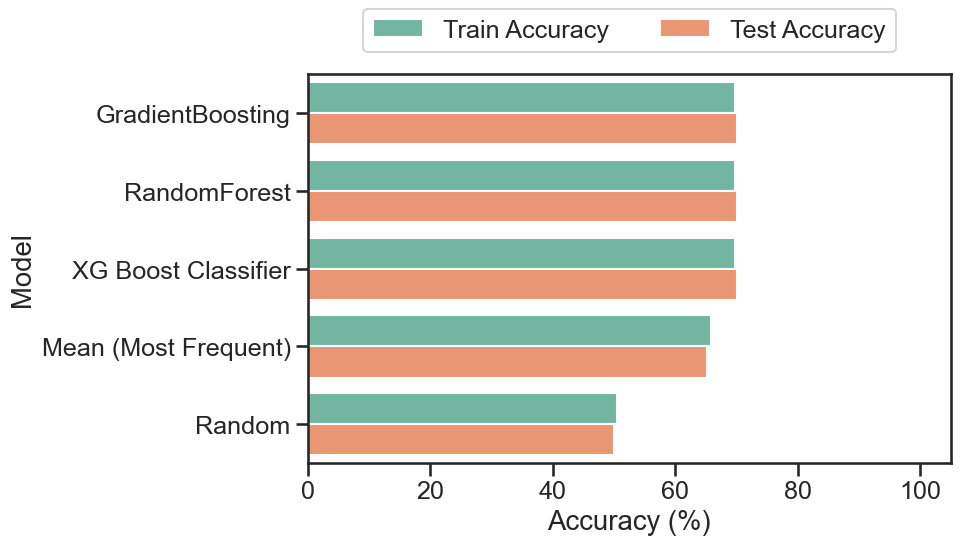

In [22]:
compare_models_with_tuning(df, 'dry_eye_disease')

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.85}
Accuracy: Test 52.90%, Train 53.09%
Precision: Test 49.76%, Train 50.51%
Recall: Test 52.90%, Train 53.09%
F1 Score: Test 38.68%, Train 39.27%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: Test 52.50%, Train 52.47%
Precision: Test 50.33%, Train 49.99%
Recall: Test 52.50%, Train 52.47%
F1 Score: Test 43.53%, Train 43.54%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Accuracy: Test 52.98%, Train 53.16%
Precision: Test 42.60%, Train 46.32%
Recall: Test 52.98%, Train 53.16%
F1 Score: Test 36.95%, Train 37.24%
------------------------------
Mean (Most

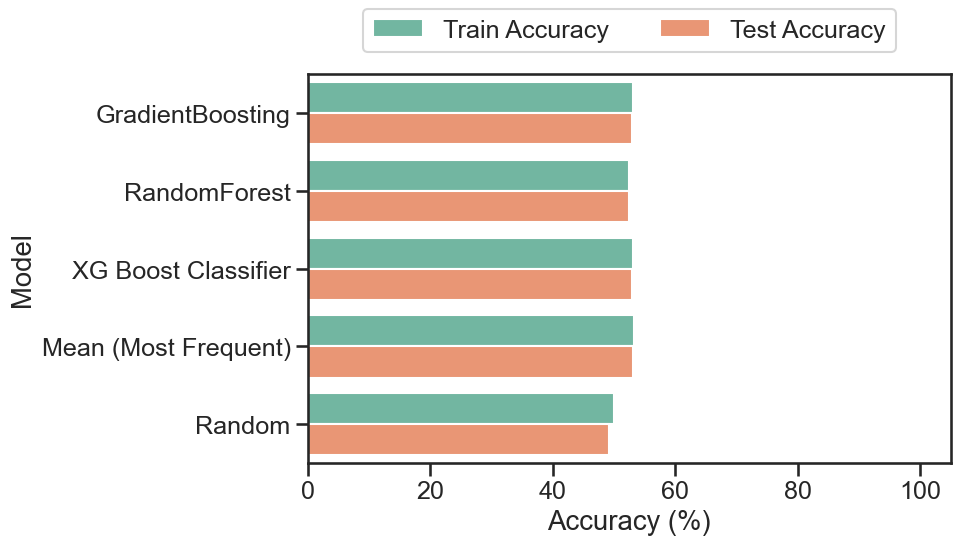

In [23]:
compare_models_with_tuning(df, 'insomnia')

In [24]:
df = df0.copy()
df = df[(df['combined_condition']=='both') | (df['combined_condition']=='none')]
#Replace 'both' with 'Y' and 'none' with 'N'
df['combined_condition'] = df['combined_condition'].replace({'both': 'Y', 'none': 'N'})
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'dry_eye_disease', 'insomnia', 'height', 'weight']
df = df.drop(columns=omit_cols)


['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition', 'bmi']


Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.85}
Accuracy: Test 69.41%, Train 65.18%
Precision: Test 70.58%, Train 65.79%
Recall: Test 69.41%, Train 65.18%
F1 Score: Test 64.33%, Train 60.13%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: Test 69.10%, Train 65.24%
Precision: Test 69.98%, Train 65.87%
Recall: Test 69.10%, Train 65.24%
F1 Score: Test 64.01%, Train 60.22%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Accuracy: Test 69.41%, Train 65.18%
Precision: Test 70.58%, Train 65.79%
Recall: Test 69.41%, Train 65.18%
F1 Score: Test 64.33%, Train 60.13%
------------------------------
Mean (Mo

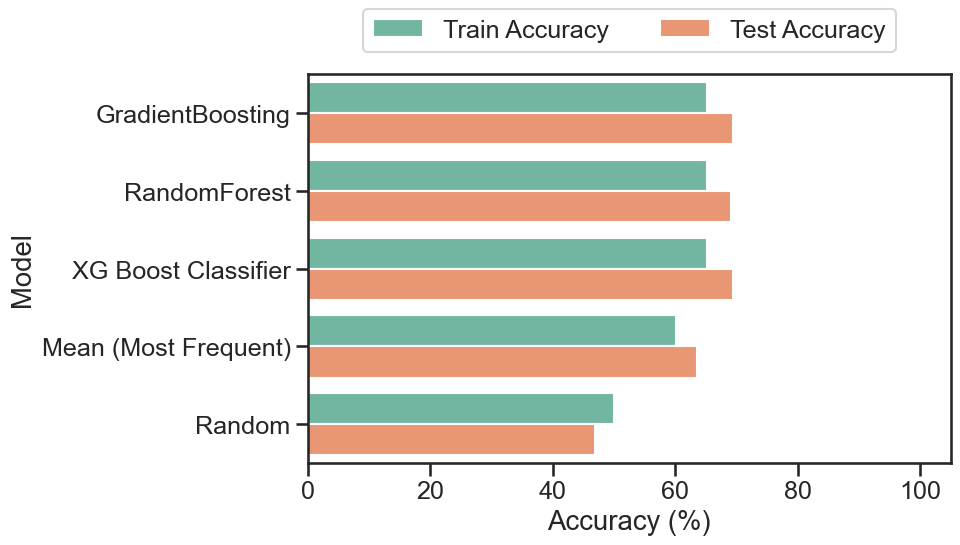

In [25]:
compare_models_with_tuning(df, 'combined_condition')